<a href="https://colab.research.google.com/github/MahmudShuvo/Autism-Detection-using-Deep-Learning/blob/main/Final_EfficientnetB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install split_folders

In [2]:
import os
import shutil
import splitfolders
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt
import datetime
import matplotlib.image as mping
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

In [4]:
import os
import splitfolders

# Define the path to the input folder
input_folder = "/content/drive/MyDrive/AutismDataset/consolidated"

# Define the path to the output folder
output_folder = "/content/output"

# Split the data into train, validation, and test sets
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))


Copying files: 2940 files [01:06, 44.18 files/s] 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the directories for training, testing, and validation
train_dir = "output/train"
test_dir = "output/test"
val_dir = "output/val"

# Create datasets for training, testing, and validation
train_data = image_dataset_from_directory(
    train_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=True,
    seed=42
)

test_data = image_dataset_from_directory(
    test_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=False,
    seed=42
)

val_data = image_dataset_from_directory(
    val_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=False,
    seed=42
)


Found 2352 files belonging to 2 classes.
Found 294 files belonging to 2 classes.
Found 294 files belonging to 2 classes.


In [7]:
class_names = train_data.class_names
class_count = len(class_names)

print("Class Names:", class_names)
print("Number of Classes:", class_count)


Class Names: ['Autistic', 'Non_Autistic']
Number of Classes: 2


In [6]:
from tqdm import tqdm

samples = []
x = 0
for item in tqdm(train_data.unbatch()):
    if x == 10:
        break
    samples.append([item[0], item[1]])
    x += 1


10it [00:01,  7.66it/s]


In [8]:
import tensorflow as tf

images = []
labels = []

for sample in samples:
    images.append(sample[0])
    label_index = tf.argmax(sample[1])
    labels.append(class_names[label_index])

print("Number of Images:", len(images))
print("Number of Labels:", len(labels))


Number of Images: 10
Number of Labels: 10


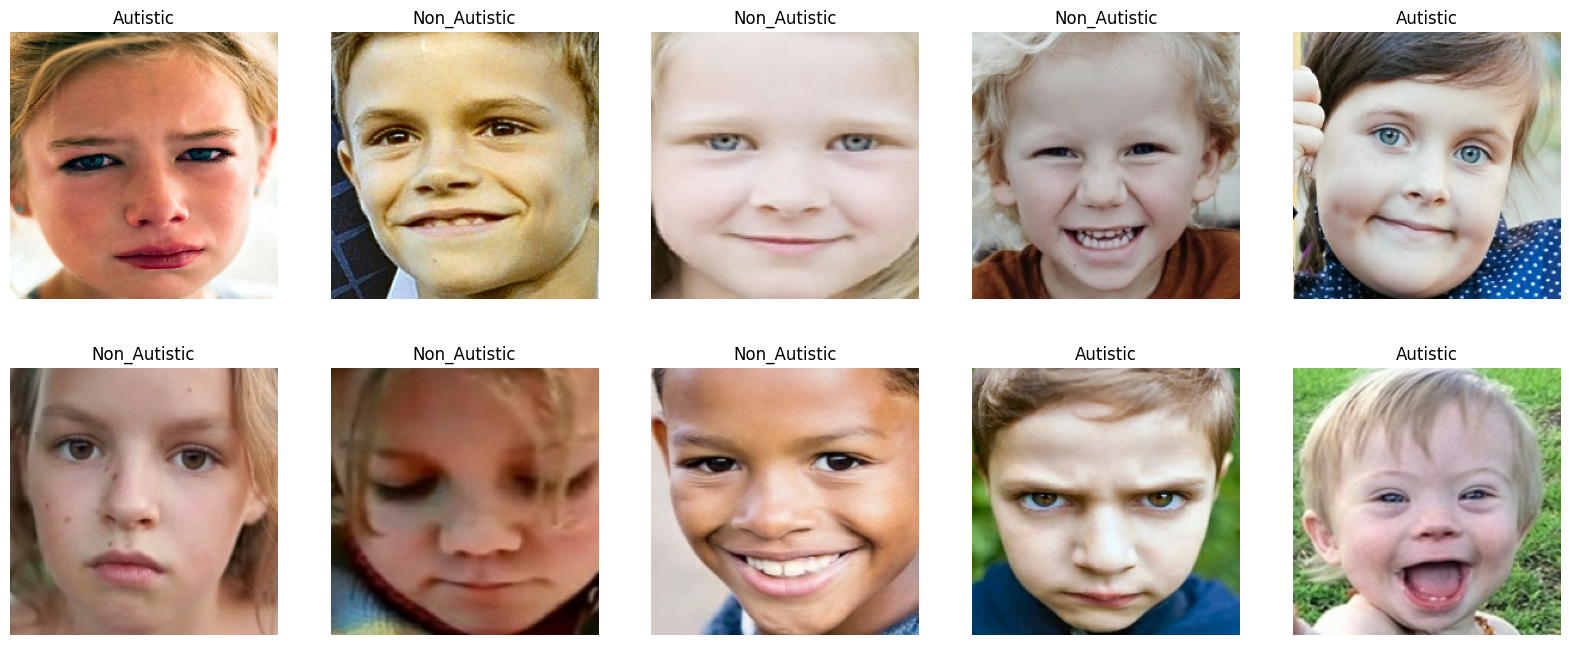

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 8))
rows = 2
cols = 5
x = 1

for image, label in zip(images, labels):
    ax = fig.add_subplot(rows, cols, x)
    ax.imshow(image/255.)  # Assuming the image data is normalized to [0, 1]
    ax.axis("off")
    ax.set_title(label)
    x += 1

plt.show()


In [10]:
input_shape = (224, 224, 3)

In [11]:


def create_early_stopper():
    earlystopper = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        min_delta=0.001,
        verbose=1
    )
    return earlystopper


In [12]:
model_name = 'EfficientNetB4'
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')

71686520/71686520 [==============================] - 0s 0us/step


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# Define additional layers
x = base_model.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.002)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.45, seed=42)(x)
output = Dense(class_count, activation='softmax')(x)

# Construct the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01, verbose=1)

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Define EfficientNetB4 base model
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling=None)

# Add GlobalAveragePooling2D layer to reduce the number of parameters
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(class_count, activation='softmax')(x)

# Construct the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [16]:
# Train the model
history = model.fit(train_data,
                    epochs=60,
                    validation_data=val_data,
                    callbacks=[early_stopper])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print("Test Accuracy:", test_accuracy)

Epoch 1/60
74/74 [==============================] - 142s 774ms/step - loss: 0.5814 - accuracy: 0.6866 - val_loss: 0.5008 - val_accuracy: 0.7653
Epoch 2/60
74/74 [==============================] - 50s 672ms/step - loss: 0.2981 - accuracy: 0.8810 - val_loss: 0.3817 - val_accuracy: 0.8231
Epoch 3/60
74/74 [==============================] - 52s 703ms/step - loss: 0.1334 - accuracy: 0.9596 - val_loss: 0.3814 - val_accuracy: 0.8503
Epoch 4/60
74/74 [==============================] - 52s 697ms/step - loss: 0.0580 - accuracy: 0.9826 - val_loss: 0.4496 - val_accuracy: 0.8605
Epoch 5/60
74/74 [==============================] - 52s 698ms/step - loss: 0.0407 - accuracy: 0.9881 - val_loss: 0.5591 - val_accuracy: 0.8333
Epoch 6/60
74/74 [==============================] - 52s 689ms/step - loss: 0.0375 - accuracy: 0.9847 - val_loss: 0.5098 - val_accuracy: 0.8571
Epoch 7/60
74/74 [==============================] - 52s 699ms/step - loss: 0.0299 - accuracy: 0.9902 - val_loss: 0.4473 - val_accuracy: 0.843